In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lfwpeople/pairsDevTrain.txt
/kaggle/input/lfwpeople/lfw-funneled.tgz
/kaggle/input/lfwpeople/pairsDevTest.txt
/kaggle/input/lfwpeople/pairs.txt


In [2]:
import os
import tarfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
# Define file paths
tgz_path = "/kaggle/input/lfwpeople/lfw-funneled.tgz"
extract_path = "/kaggle/working/lfw_faces"

# Extract once
if not os.path.exists(extract_path):
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
    print("Dataset extracted successfully.")
else:
    print(" Dataset already extracted.")


Dataset extracted successfully.


In [4]:
# Check what's inside extract_path
os.listdir(extract_path)


['lfw_funneled']

In [5]:
# Go inside 'lfw-funneled'
nested_path = os.path.join(extract_path, "lfw_funneled")

# List all people (folders)
people = sorted([
    p for p in os.listdir(nested_path)
    if os.path.isdir(os.path.join(nested_path, p))
])

print(" Total people found:", len(people))
print(" First 5 people:", people[:5])


 Total people found: 5749
 First 5 people: ['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson']


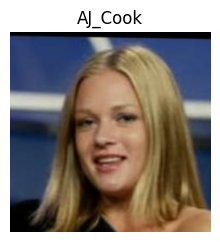

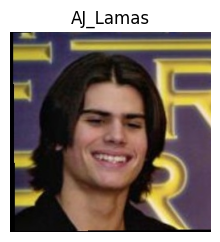

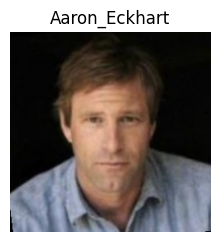

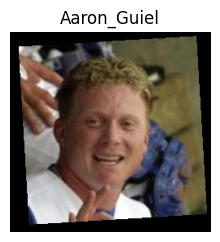

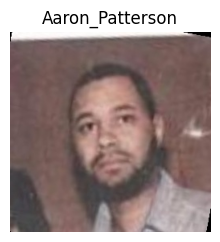

In [6]:
def show_faces(person, num=5):
    person_dir = os.path.join(nested_path, person)
    images = os.listdir(person_dir)[:num]

    plt.figure(figsize=(15,5))
    for i, image in enumerate(images):
        img_path = os.path.join(person_dir, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(person)
        plt.axis('off')
    plt.show()
for person in people[:5]:
    show_faces(person)

In [7]:
import shutil

dataset_path = "/kaggle/working/faces_dataset"
os.makedirs(dataset_path, exist_ok=True)

for person in tqdm(people):
    person_dir = os.path.join(nested_path, person)
    images = os.listdir(person_dir)

    if len(images) < 2:
        continue 

    dest_dir = os.path.join(dataset_path, person)
    os.makedirs(dest_dir, exist_ok=True)

    for img_name in images:
        src_path = os.path.join(person_dir, img_name)
        dst_path = os.path.join(dest_dir, img_name)
        shutil.copy(src_path, dst_path)


100%|██████████| 5749/5749 [00:01<00:00, 4178.40it/s]


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 100
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = train_gen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

val_data = train_gen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)


2025-06-08 09:16:05.079972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749374165.309447      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749374165.373538      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 8092 images belonging to 1680 classes.
Found 1072 images belonging to 1680 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-08 09:16:21.198777: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


253/253 ━━━━━━━━━━━━━━━━━━━━ 97s 364ms/step - accuracy: 0.0336 - loss: 7.4657 - val_accuracy: 0.1017 - val_loss: 6.5357
Epoch 2/15
253/253 ━━━━━━━━━━━━━━━━━━━━ 140s 357ms/step - accuracy: 0.0524 - loss: 7.0881 - val_accuracy: 0.1007 - val_loss: 6.5955
Epoch 3/15
253/253 ━━━━━━━━━━━━━━━━━━━━ 90s 357ms/step - accuracy: 0.0575 - loss: 6.9685 - val_accuracy: 0.1063 - val_loss: 6.2161
Epoch 4/15
253/253 ━━━━━━━━━━━━━━━━━━━━ 89s 353ms/step - accuracy: 0.0642 - loss: 6.8002 - val_accuracy: 0.1157 - val_loss: 6.6318
Epoch 5/15
253/253 ━━━━━━━━━━━━━━━━━━━━ 87s 345ms/step - accuracy: 0.0727 - loss: 6.6036 - val_accuracy: 0.1549 - val_loss: 5.6705
Epoch 6/15
253/253 ━━━━━━━━━━━━━━━━━━━━ 87s 346ms/step - accuracy: 0.0831 - loss: 6.3708 - val_accuracy: 0.1483 - val_loss: 5.4787
Epoch 7/15
253/253 ━━━━━━━━━━━━━━━━━━━━ 87s 343ms/step - accuracy: 0.0955 - loss: 6.2130 - val_accuracy: 0.1754 - val_loss: 5.4377
Epoch 8/15
253/253 ━━━━━━━━━━━━━━━━━━━━ 87s 342ms/step - accuracy: 0.1100 - loss: 6.0028 - va

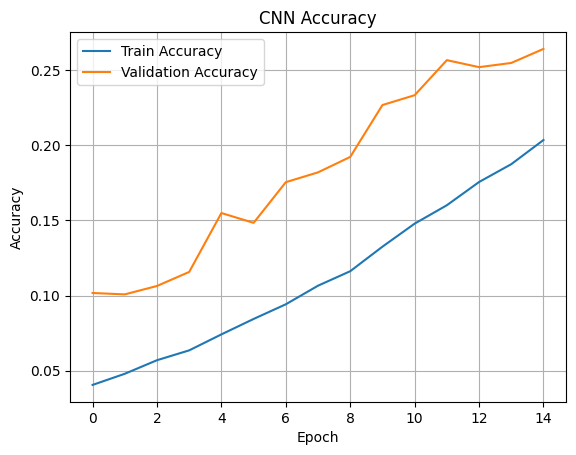

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Final validation Accuracy: {val_acc:.2%}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.2908 - loss: 4.4629
Final validation Accuracy: 26.40%


In [14]:
model.save("lfw_cnn_model.h5")

In [15]:
class_names = list(train_data.class_indices.keys())


In [16]:
import random


x_batch, y_batch = next(val_data)


idx = random.randint(0, len(x_batch) - 1)
img = x_batch[idx]
true_label = int(y_batch[idx])


In [17]:

pred = model.predict(np.expand_dims(img, axis=0))
predicted_label = np.argmax(pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


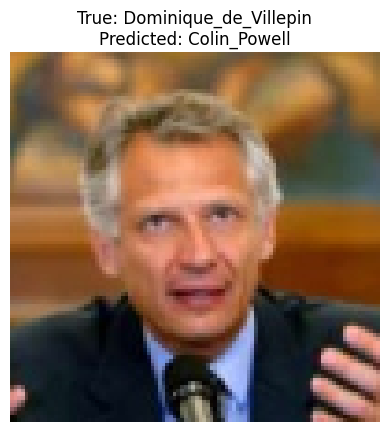

In [18]:
plt.imshow(img)
plt.axis('off')
plt.title(f"True: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}")
plt.show()


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os


In [20]:
IMG_SIZE = 100
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_path = "/kaggle/working/faces_dataset"

# Load dataset
dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Split manually
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [21]:
class FaceCNN(nn.Module):
    def __init__(self, num_classes):
        super(FaceCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceCNN(num_classes=len(dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)

    acc = correct.double() / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Accuracy: {acc:.4f}")


Epoch 1/10, Loss: 1687.6759, Accuracy: 0.0416
Epoch 2/10, Loss: 1640.4053, Accuracy: 0.0513
Epoch 3/10, Loss: 1606.6568, Accuracy: 0.0547
Epoch 4/10, Loss: 1592.7119, Accuracy: 0.0573
Epoch 5/10, Loss: 1561.8583, Accuracy: 0.0588
Epoch 6/10, Loss: 1548.1382, Accuracy: 0.0588
Epoch 7/10, Loss: 1528.0400, Accuracy: 0.0629
Epoch 8/10, Loss: 1522.4106, Accuracy: 0.0634
Epoch 9/10, Loss: 1489.9290, Accuracy: 0.0682
Epoch 10/10, Loss: 1471.2458, Accuracy: 0.0705


In [24]:
model.eval()
correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)

val_acc = correct.double() / len(val_loader.dataset)
print(f"Final Validation Accuracy (PyTorch): {val_acc:.2%}")


Final Validation Accuracy (PyTorch): 7.53%
